In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft
from scipy.stats import wasserstein_distance

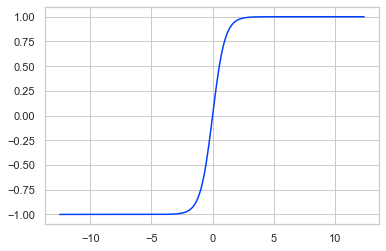

In [3]:
from scipy import signal
import math
x = np.arange(-12.5, 12.5, 0.1)
y = np.zeros(250)
y = np.tanh(x)
plt.plot(x, y)
plt.show()

In [4]:
#x = np.arange(1, 31, 1)
signal_3 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

# FFT regeneration

In [5]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    #freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_img
freq_ampli3i = freq(signal_3)

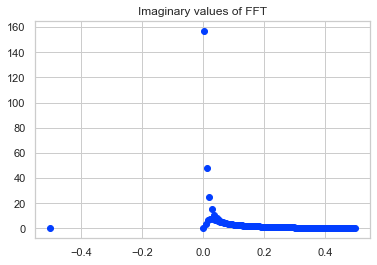

In [6]:
#sns.lineplot(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.xlim(0, 0.2)
#plt.title('Real values of FFT')
#plt.show()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

In [7]:
np.shape(freq_ampli3i)

(126, 2)

In [8]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [9]:
#best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      

In [10]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(n_components=15) 

WEIGHTS - [0.00793651 0.00793651 0.00793651 0.13498177 0.00793651 0.00793651
 0.07586881 0.25020621 0.08949971 0.00793651 0.03063721 0.0760062
 0.16971891 0.10958912 0.01587302] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 8.00000000e-03  3.84368401e+00]
 [ 4.00000000e-03  1.57120647e+02]
 [ 1.20000000e-02  4.77214213e+01]
 [ 2.52371149e-01  9.92851527e-01]
 [ 2.80000000e-02  1.53175883e+01]
 [ 2.00000000e-02  2.47943215e+01]
 [ 6.00898775e-02  5.28208077e+00]
 [ 4.34858998e-01  2.10462952e-01]
 [ 1.40563749e-01  2.13546108e+00]
 [ 3.60000000e-02  1.06049991e+01]
 [ 2.88950585e-02  7.22399469e+00]
 [ 9.87911306e-02  3.15989383e+00]
 [ 3.29188607e-01  5.99868614e-01]
 [ 1.90728627e-01  1.47619343e+00]
 [-2.50000000e-01  9.77713517e-40]] 



In [11]:
#Sampling
#z1,_ = best_gmm0.sample(126)
z1i,_ = best_gmm0i.sample(126)

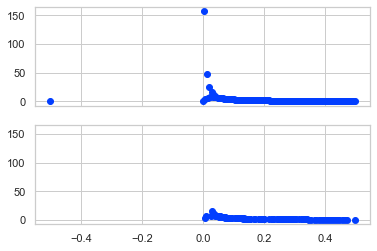

In [12]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

In [13]:
#sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [14]:
#sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
#sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [15]:
f = fftpack.fftfreq(250)       
sd = dict(zip(np.round(f,3),np.zeros(len(f))))
#sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))
#samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [16]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.004: 0.0,
 0.008: 6.41811576887566j,
 0.012: 0.0,
 0.016: 0.0,
 0.02: 0.0,
 0.024: 6.824690850683546j,
 0.028: 15.31810249186373j,
 0.032: 0.0,
 0.036: 21.210609352057176j,
 0.04: 6.651837256074332j,
 0.044: 0.0,
 0.048: 6.287776793103284j,
 0.052: 5.5947764338219095j,
 0.056: 11.32008204137055j,
 0.06: 5.025709717606506j,
 0.064: 0.0,
 0.068: 4.632895233810267j,
 0.072: 8.224009039202635j,
 0.076: 4.0249938173879665j,
 0.08: 3.7891131019964854j,
 0.084: 3.6376648447423414j,
 0.088: 3.132317970809484j,
 0.092: 0.0,
 0.096: 3.2875553512090985j,
 0.1: 0.0,
 0.104: 2.9158021498134854j,
 0.108: 2.6901523592066607j,
 0.112: 2.6515819310075908j,
 0.116: 0.0,
 0.12: 2.451177788074745j,
 0.124: 2.429424563976927j,
 0.128: 2.3956821658754017j,
 0.132: 4.608587657283398j,
 0.136: 0.0,
 0.14: 2.1799704407663283j,
 0.144: 2.107545826889838j,
 0.148: 1.9853246526199897j,
 0.152: 1.9331033462304206j,
 0.156: 0.0,
 0.16: 0.0,
 0.164: 1.7379241114166157j,
 0.168: 0.0,
 0.172: 1.661490347

In [17]:
value = list(sd.values())

# Final IFFT

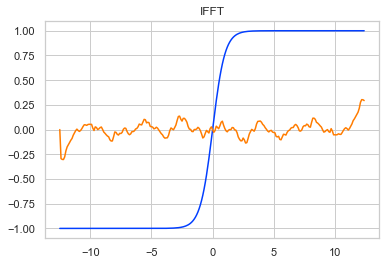

In [18]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(signal_3['Time'], signal_3['Value'])
plt.plot(x,ift)

# Log FFT regeneration

In [19]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    #freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_img
freq_ampli3i = freq(signal_3)

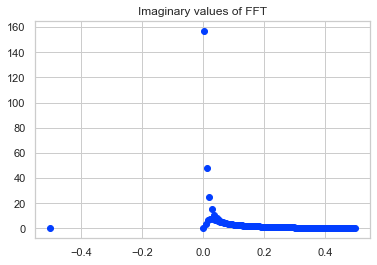

In [20]:
#sns.lineplot(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.xlim(0, 0.2)
#plt.title('Real values of FFT')
#plt.show()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

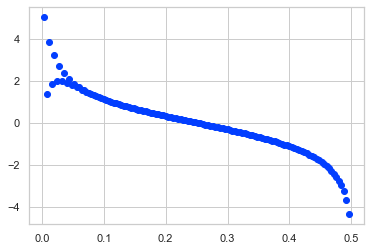

In [21]:
#freq_ampli3['Ampli'] = np.log(freq_ampli3["Ampli"])
#freq_ampli3 = freq_ampli3.loc[freq_ampli3['Ampli'] != float('-inf')]
#freq_ampli3 = freq_ampli3.dropna()
#plt.scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.show()
freq_ampli3i['Ampli'] = np.log(freq_ampli3i["Ampli"])
freq_ampli3i = freq_ampli3i.loc[freq_ampli3i['Ampli'] != float('-inf')]
freq_ampli3i = freq_ampli3i.fillna(0)
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.show()

In [22]:
np.shape(freq_ampli3i)

(124, 2)

In [23]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [24]:
#best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      # GMM on imaginary part of FFT data

In [25]:
'''print(best_gmm0, '\n')
print('WEIGHTS -', best_gmm0.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')'''

"print(best_gmm0, '\n')\nprint('WEIGHTS -', best_gmm0.weights_, '\n')\nprint('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')"

In [26]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(n_components=11) 

WEIGHTS - [0.12448701 0.11710032 0.0669851  0.03205024 0.12816629 0.31923199
 0.04228867 0.09195893 0.04514117 0.00806452 0.02452576] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 1.38834375e-01  7.70711035e-01]
 [ 3.56808873e-01 -7.34087391e-01]
 [ 4.48213773e-01 -1.82507746e+00]
 [ 2.39693846e-02  3.04155888e+00]
 [ 7.48947316e-02  1.44210304e+00]
 [ 2.48791791e-01  7.91871011e-03]
 [ 4.75274207e-01 -2.58520656e+00]
 [ 4.08782121e-01 -1.23223407e+00]
 [ 2.95795859e-02  1.84188731e+00]
 [ 4.00000000e-03  5.05701396e+00]
 [ 4.91888803e-01 -3.76833230e+00]] 



In [27]:
#Sampling
#z1,_ = best_gmm0.sample(126)
z1i,_ = best_gmm0i.sample(126)

In [28]:
'''fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.show()
ax[1].scatter(z1[:, 0], z1[:, 1])
plt.show()'''

"fig, ax = plt.subplots(2, sharex='all', sharey='all')\nax[0].scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])\n#plt.show()\nax[1].scatter(z1[:, 0], z1[:, 1])\nplt.show()"

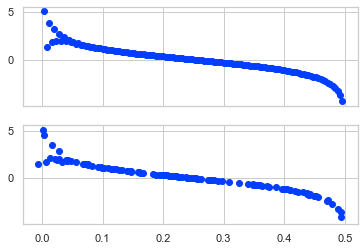

In [29]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

In [30]:
#print('Real: ', wasserstein_distance(freq_ampli3['Ampli'], z1[:, 1]))
#print('Imag: ', wasserstein_distance(freq_ampli3i['Ampli'], z1i[:, 1]))

In [31]:
z1i[:, 1] = np.exp(z1i[:, 1])

In [32]:
'''plt.figure(figsize=(20,10))
sns.distplot(freq_ampli3['Ampli'], kde = True)
sns.distplot(z1[:, 1], kde = True)
#plt.ylim(0.0, 0.2)
plt.show()'''

"plt.figure(figsize=(20,10))\nsns.distplot(freq_ampli3['Ampli'], kde = True)\nsns.distplot(z1[:, 1], kde = True)\n#plt.ylim(0.0, 0.2)\nplt.show()"

In [33]:
#sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [34]:
#sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
#sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [35]:
#sample_1 = sample_1[(sample_1.Ampli>1) | (sample_1.Ampli<-1)]
#sample_1i = sample_1i[(sample_1i.Ampli>1) | (sample_1i.Ampli<-1)]

In [36]:
f = fftpack.fftfreq(250)                                    # The frequency corresponding to each value in FFT is stored in 'f'

In [37]:
sd = dict(zip(np.round(f,3),np.zeros(len(f))))

In [38]:
#sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))

In [39]:
#samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [40]:
'''for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.001 in sd:
        sd[i+0.001] = samp_1[i]
        sd[-(i+0.001)] = samp_1[i]
    elif i-0.001 in sd:
        sd[i-0.001] = samp_1[i]
        sd[-(i-0.001)] = samp_1[i]
sd'''

'for i in samp_1.keys():\n    if i in sd:\n        sd[i] = samp_1[i]\n        sd[-i] = samp_1[i]\n    elif i+0.001 in sd:\n        sd[i+0.001] = samp_1[i]\n        sd[-(i+0.001)] = samp_1[i]\n    elif i-0.001 in sd:\n        sd[i-0.001] = samp_1[i]\n        sd[-(i-0.001)] = samp_1[i]\nsd'

In [41]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.004: 95.84518692399969j,
 0.008: 5.499191674594644j,
 0.012: 8.443814676556048j,
 0.016: 32.90275968766192j,
 0.02: 7.332530289958011j,
 0.024: 6.449050454835398j,
 0.028: 24.138470443513697j,
 0.032: 5.530501135992207j,
 0.036: 0.0,
 0.04: 12.547115784156603j,
 0.044: 6.7524125847364065j,
 0.048: 5.904506836977864j,
 0.052: 0.0,
 0.056: 5.3683780477019765j,
 0.06: 0.0,
 0.064: 0.0,
 0.068: 4.5165794476381445j,
 0.072: 8.962606047034992j,
 0.076: 8.389213394231042j,
 0.08: 0.0,
 0.084: 0.0,
 0.088: 0.0,
 0.092: 3.348347367703862j,
 0.096: 3.19735085342841j,
 0.1: 3.013435793593298j,
 0.104: 2.999854915790841j,
 0.108: 2.8111989309215737j,
 0.112: 2.6289279355287234j,
 0.116: 2.6011335913391096j,
 0.12: 0.0,
 0.124: 0.0,
 0.128: 2.3771929911216243j,
 0.132: 2.3205446618864602j,
 0.136: 0.0,
 0.14: 0.0,
 0.144: 0.0,
 0.148: 1.9530134986659997j,
 0.152: 0.0,
 0.156: 0.0,
 0.16: 3.634976469342563j,
 0.164: 1.7548924582953807j,
 0.168: 1.7346970960147128j,
 0.172: 0.0,
 0.176:

In [42]:
value = list(sd.values())

# Final IFFT 

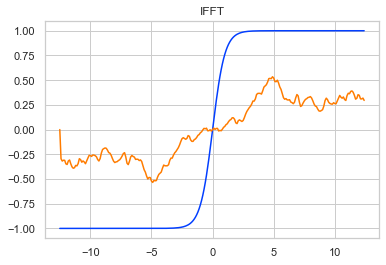

In [43]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(signal_3['Time'], signal_3['Value'])
plt.plot(x,ift)

# Cepstrum

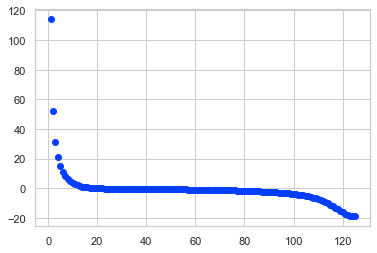

In [44]:
frame_size = signal_3.shape[0]
Fs = 1
dt = 1/Fs
freq_vector = np.fft.rfftfreq(frame_size, d=dt)
y = np.array(signal_3['Value'])
yf = fftpack.fft(y)
yf1 = yf[yf != 0]
quefrency = np.fft.rfftfreq(np.log(yf1).size,freq_vector[1] - freq_vector[0])
cepstrum = np.fft.rfft(np.log(np.abs(yf1)))
cep = pd.DataFrame(zip(quefrency,cepstrum.real),columns=['Quefrency','Cepstrum'])
cep = cep.iloc[1:,:]
plt.scatter(cep.Quefrency,cep.Cepstrum)

In [45]:
dfx = cep
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm3 = gmm

In [46]:
print(best_gmm3, '\n')
print('WEIGHTS -', best_gmm3.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm3.means_, '\n')

GaussianMixture(n_components=21) 

WEIGHTS - [0.03190176 0.04800608 0.05607396 0.008      0.04802989 0.06546383
 0.04804703 0.008      0.06397541 0.07161124 0.05600384 0.016
 0.11084876 0.04801066 0.03996971 0.06408492 0.05602622 0.05598891
 0.008      0.05595621 0.04000155] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 27.49653598  -0.34376232]
 [100.49798076  -4.03937243]
 [ 71.99332706  -1.35144972]
 [  2.          51.86664784]
 [117.50224018 -13.60399642]
 [ 47.4290382   -0.66767604]
 [  8.50344865   5.95012702]
 [  1.         114.30516046]
 [ 86.49604153  -2.20344798]
 [ 64.0120185   -1.06538429]
 [ 15.0061638    0.9152553 ]
 [  4.5         17.81628392]
 [ 36.42296975  -0.48952664]
 [106.49905712  -5.77558078]
 [123.00150137 -18.27414375]
 [ 55.53208858  -0.83591576]
 [ 93.99558971  -2.96999182]
 [ 78.99837356  -1.69159033]
 [  3.          31.13417224]
 [ 22.00321118  -0.13579802]
 [111.99992113  -8.692173  ]] 



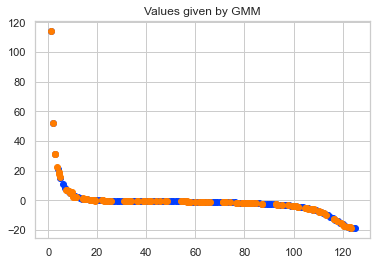

In [47]:
z3,_ = best_gmm3.sample(125)
plt.title('Actual data')
plt.scatter(cep['Quefrency'], cep['Cepstrum'])
#plt.show()
plt.title('Values given by GMM')
plt.scatter(z3[:,0],z3[:,1])
plt.show()

In [48]:
wasserstein_distance(cep['Cepstrum'], z3[:, 1])

0.876309444860166

In [49]:
def dim(df):
    d = []
    for i,j in df.values.tolist():
        for k in range(round(j)):
            d.append(i)
    return d
list(np.array(cep))
c = dim(cep)
cep.sort_values(by=['Cepstrum'],ascending = False)
np.shape(c)

(276,)

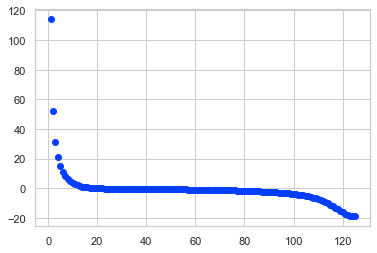

<AxesSubplot:ylabel='Density'>

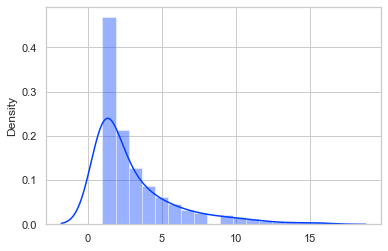

In [50]:
plt.scatter(cep['Quefrency'], cep['Cepstrum'])
plt.show()
sns.distplot(c)

In [51]:
c = np.array(c).reshape(-1,1)
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm
best_gmm22 = GMM_fit(c)

In [52]:
print(best_gmm22, '\n')
print('WEIGHTS -', best_gmm22.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm22.means_, '\n')

GaussianMixture(covariance_type='tied', n_components=16) 

WEIGHTS - [0.07608696 0.41304348 0.01449275 0.02898551 0.00724638 0.1884058
 0.11231884 0.00362319 0.05434783 0.03985507 0.02173913 0.01811594
 0.01086957 0.00362319 0.00362319 0.00362319] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 4.]
 [ 1.]
 [10.]
 [ 7.]
 [12.]
 [ 2.]
 [ 3.]
 [15.]
 [ 5.]
 [ 6.]
 [ 8.]
 [ 9.]
 [11.]
 [14.]
 [16.]
 [13.]] 



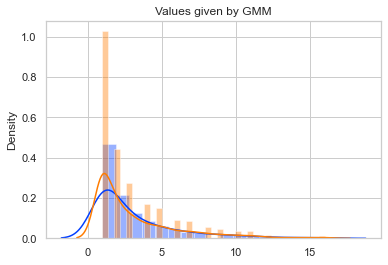

In [53]:
z22,_ = best_gmm22.sample(3190)
plt.title('Actual data')
sns.distplot(c)
#plt.show()
plt.title('Values given by GMM')
sns.distplot(z22)
plt.show()

In [54]:
wasserstein_distance(c.flatten(), z22.flatten())

0.06106837683572153